# LXMERT
### Model 구조
1) Question and Image Representation 

2) Deep Co-Attention Learning 

3) Multimodal Fusion and Output classifier

### Encoder
![encoder](images/lxmert1.png)
이 모델은 3개의 Encoder로 이루어져 있다 (Objet-Relationship Encoder, Language Encdoer, Cross-Modality Encoder)

(1) Word Embedding 이후 Language Encoder가 있어서 question을 인코딩한다 = Question Representation 

(2) Object Detection feature로 RoI (Region of Interest) feature 와 Pos(Position) feature를 합쳐 다시 Object-Relationship Encoder를 거치게 되어 있어서, object-relationship 관계 구조를 학습할 수 있다 = Image Representation 

(3) LXMERT의 Cross-Modality Encoder 부분에서 multi modality 간 co-attention 역할을 한다

# Huggingface - LXMERT

``` python
# 예제코드
$ pip uninstall transformers
$ cd ~/aiffel
$ git clone https://github.com/huggingface/transformers.git
$ cd transformers
$ pip install -e .
$ pip install -r ~/aiffel/transformers/examples/lxmert/requirements.txt

# 예제코드 중 일부 다운로드
$ mkdir -p ~/aiffel/lxmert
$ cd ~/aiffel/lxmert
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/lxmert.zip
$ unzip lxmert.zip
```

In [1]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

### VQA2 데이터셋

In [2]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL) # URL에 게시된 json 형태의 데이터를 파싱해서 list로 변환해 제공하는 메소드
print(len(objids))
print(objids[:30])

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [3]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [4]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


VQA2 데이터셋
- 1600개인 object와 400개인 attribute의 차이 : cup is white라는 문장이 있다면 cup이 object가 되고 white가 attribute가 됩니다. 
- 두 dictionary를 합쳐도 괜찮지 않을까 싶은 생각이 들지만, 그래프 구조에서 이를 분리하는 것이 일반적입니다.
- 3129개나 되는 VQA answer들은 VQA 퀴즈를 풀었을 때 답이 될 수 있는 것을 모아놓은 것입니다. 여기서 한가지 알수 있는 것은, VQA task에서 answer를 text generation 같은 일반적인 방법으로 만들어내는 것은 아니라는 점입니다. 여기서는 3129개의 정답 중 가장 확률이 높은 것 한가지를 선택하는 classification 문제로 바꾸어 놓은 것입니다. 

VQA 컨텍스트 이미지 예제
![example](https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg)
- 위 그림을 선택하여 Preprocess라는 전처리 클래스를 통해 이미지 피처링용 F-RCNN 모델에 입력할 데이터로 가공합니다.
- 이 전처리 클래스는 제공한 processing_image.py에 포함되어 있습니다.

In [5]:
# 위 이미지의 URL
URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [15]:
print(images)
print(sizes)
print(scales_yx)

tensor([[[[  37.0199,   32.2233,   25.0255,  ...,  -40.9723,  -31.3756,
            -24.9801],
          [  31.0199,   27.6623,   22.6238,  ...,  -42.1717,  -31.8553,
            -24.9801],
          [  22.0199,   20.8207,   19.0213,  ...,  -43.9708,  -32.5748,
            -24.9801],
          ...,
          [ -85.9802,  -83.9816,  -80.9824,  ...,   71.0138,   63.8164,
             59.0198],
          [ -87.7801,  -85.0620,  -80.9833,  ...,   66.2157,   61.1775,
             57.8199],
          [ -88.9801,  -85.7823,  -80.9838,  ...,   63.0170,   59.4182,
             57.0199]],

         [[  44.0535,   42.4546,   40.0554,  ...,  -27.9406,  -20.7431,
            -15.9465],
          [  49.2535,   44.4569,   37.2591,  ...,  -25.1393,  -16.2624,
            -10.3465],
          [  57.0535,   47.4602,   33.0647,  ...,  -20.9372,   -9.5412,
             -1.9465],
          ...,
          [ -99.9466,  -97.5482,  -93.9492,  ...,   52.0463,   43.6493,
             38.0533],
          [-101.74

In [7]:
test_questions_for_url1 = [
    "Where is this scene?",
    "what is the man riding?",
    "What is the man wearing?",
    "What is the color of the horse?"
]

# 모델 구성 (1) F-RCNN

- object detection 모델을 활용해서 RoI (Region of Interest), Pos feature를 인식해서 object, attribute dictionary로 연결짓는다
- 위치정보까지 함께 고려되므로 object간 어떤 relation이 있는지까지 함께 추론 가능하다

In [17]:
# F-RCNN : 컴퓨터 비전의 object detection 분야의 대표적인 모델
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel0035/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [9]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [10]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [11]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.6930e+02, 2.1428e+02, 4.8507e+02, 4.6975e+02],
         [1.0072e+02, 2.5157e+02, 3.9440e+02, 4.8000e+02],
         [5.8607e+02, 0.0000e+00, 6.3892e+02, 3.5348e+02],
         [6.0813e+02, 6.1844e+01, 6.3753e+02, 4.2312e+02],
         [2.8151e+02, 1.6208e+02, 3.2836e+02, 1.9436e+02],
         [1.5756e+02, 9.3071e+01, 3.9201e+02, 4.6143e+02],
         [2.2245e+02, 2.9141e+02, 5.6593e+02, 4.8000e+02],
         [4.1366e+01, 1.8160e+02, 3.4989e+02, 4.5049e+02],
         [1.3899e+01, 1.7041e+00, 2.0780e+02, 4.3721e+02],
         [3.8143e+02, 3.1056e+02, 6.1871e+02, 4.1796e+02],
         [2.6148e+02, 1.9268e+02, 3.6299e+02, 4.2911e+02],
         [2.0384e+02, 0.0000e+00, 3.0062e+02, 2.7995e+02],
         [2.9271e+00, 0.0000e+00, 1.2306e+02, 3.5311e+02],
         [2.4660e+02, 1.5944e+02, 3.4745e+02, 3.6034e+02],
         [5.5263e+01, 2.7269e+01, 1.2843e+02, 3.8614e+02],
         [4.4270e-01, 3.3880e+02, 5.0326e+02, 4.7818e+02],
         [1.7163e+02, 3.7074e+02, 4.6254e+02, 4.6932e+02

In [18]:
# 실제로 LXMERT의 입력으로 활용될 RoI feature 추출
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.3681e+00,
          3.4300e-03, 7.7600e+00],
         [0.0000e+00, 1.4429e-02, 1.7533e-01,  ..., 6.4004e+00,
          0.0000e+00, 6.6364e+00],
         [0.0000e+00, 0.0000e+00, 4.1719e-03,  ..., 2.0413e-01,
          8.4239e-01, 3.4729e+00],
         ...,
         [0.0000e+00, 8.2577e-01, 4.4683e-01,  ..., 6.3485e+00,
          4.1949e-02, 3.9396e-01],
         [0.0000e+00, 1.7906e-01, 1.4289e-01,  ..., 2.8292e+00,
          6.5108e-01, 1.2135e-02],
         [0.0000e+00, 2.0028e-01, 3.7835e-03,  ..., 8.0951e+00,
          6.9268e-01, 1.3321e-01]]])
-------------
torch.Size([1, 36, 2048])


좌표값 대부분의 값이 0~1 사이의 소수로 이루어져 있다. 좌표값 등이 전처리 단계에서 전체 이미지 width, height를 1로 했을 때의 기준으로 normalize된 것이다.

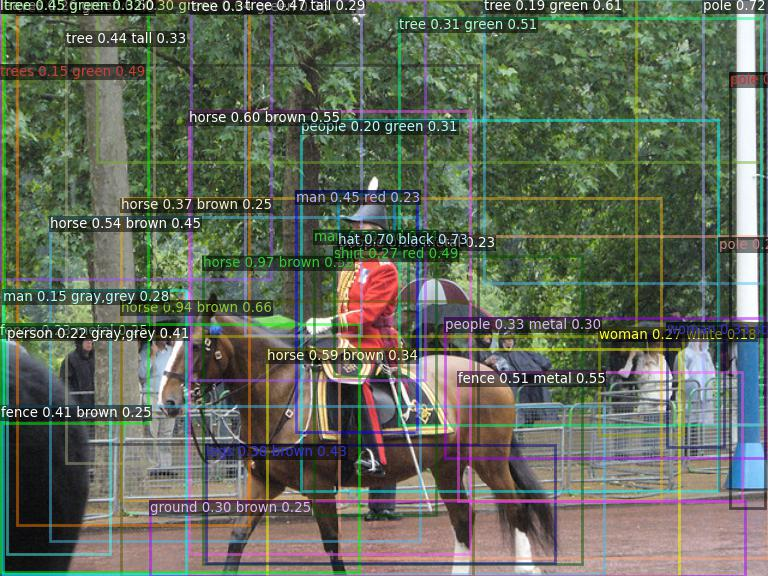

In [13]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [22]:
# 모델에 입력할 feature
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [23]:
normalized_boxes

tensor([[[2.6453e-01, 4.4641e-01, 7.5791e-01, 9.7864e-01],
         [1.5738e-01, 5.2410e-01, 6.1626e-01, 1.0000e+00],
         [9.1574e-01, 0.0000e+00, 9.9831e-01, 7.3642e-01],
         [9.5020e-01, 1.2884e-01, 9.9614e-01, 8.8150e-01],
         [4.3986e-01, 3.3766e-01, 5.1307e-01, 4.0491e-01],
         [2.4619e-01, 1.9390e-01, 6.1251e-01, 9.6132e-01],
         [3.4758e-01, 6.0711e-01, 8.8427e-01, 1.0000e+00],
         [6.4634e-02, 3.7834e-01, 5.4670e-01, 9.3853e-01],
         [2.1717e-02, 3.5502e-03, 3.2468e-01, 9.1085e-01],
         [5.9599e-01, 6.4699e-01, 9.6673e-01, 8.7076e-01],
         [4.0856e-01, 4.0141e-01, 5.6717e-01, 8.9399e-01],
         [3.1851e-01, 0.0000e+00, 4.6972e-01, 5.8323e-01],
         [4.5737e-03, 0.0000e+00, 1.9228e-01, 7.3565e-01],
         [3.8531e-01, 3.3217e-01, 5.4290e-01, 7.5071e-01],
         [8.6348e-02, 5.6811e-02, 2.0067e-01, 8.0447e-01],
         [6.9172e-04, 7.0583e-01, 7.8634e-01, 9.9620e-01],
         [2.6818e-01, 7.7238e-01, 7.2272e-01, 9.7775e-01

In [24]:
features

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.3681e+00,
          3.4300e-03, 7.7600e+00],
         [0.0000e+00, 1.4429e-02, 1.7533e-01,  ..., 6.4004e+00,
          0.0000e+00, 6.6364e+00],
         [0.0000e+00, 0.0000e+00, 4.1719e-03,  ..., 2.0413e-01,
          8.4239e-01, 3.4729e+00],
         ...,
         [0.0000e+00, 8.2577e-01, 4.4683e-01,  ..., 6.3485e+00,
          4.1949e-02, 3.9396e-01],
         [0.0000e+00, 1.7906e-01, 1.4289e-01,  ..., 2.8292e+00,
          6.5108e-01, 1.2135e-02],
         [0.0000e+00, 2.0028e-01, 3.7835e-03,  ..., 8.0951e+00,
          6.9268e-01, 1.3321e-01]]])

# 모델 구성 (2) LxmertTokenizer

In [25]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [29]:
test_question = ["what is the man riding?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt" # Return PyTorch torch.Tensor objects.
)

In [30]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 1996, 2158, 5559, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [33]:
print(inputs.token_type_ids)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


# 모델 구성 (3) LxmertModel
### LXMERT pretrained model 활용
![image2](images/lxmert2.png)

In [31]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [34]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-4.8003, -2.0933, -5.0623,  ..., -3.4784,  0.5502, -0.9368]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

활용한 모델이 정확히는 LxmertForQuestionAnswering이라는 모델로서, LXMERT 모델 파라미터를 활용해서 VQA 문제에 대한 답만 inference 하는 모델이었기 때문에, question_answering_score 항목만 의미있는 값이 나오고, 그 외 대부분의 항목은 None으로 채워져 있다.

만약 5개의 task를 풀어야 하는 pretrain용 모델을 활용했다면 같은 파라미터를 가지고도 훨씬 다양한 output을 출력했을 것이다

In [35]:
# question_answering_score : 3129가지 answer dictionary 에 대한 각각의 score
# 이 score가 가장 높은 것이 답이 된다
len(output_vqa["question_answering_score"][0])

3129

In [36]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([315])

In [37]:
vqa_answers[315]

'horse'

In [38]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['what is the man riding?']
prediction from LXMERT VQA: horse


# VAQ 성능검증

In [39]:
test_questions_for_url1 = [
    "Where is this scene?",
    "what is the man riding?",
    "What is the man wearing?",
    "What is the color of the horse?"
]

for test_question in test_questions_for_url1:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: outdoors
Question: ['what is the man riding?']
prediction from LXMERT VQA: horse
Question: ['What is the man wearing?']
prediction from LXMERT VQA: suit
Question: ['What is the color of the horse?']
prediction from LXMERT VQA: brown


### 다른 이미지로 테스트

In [40]:
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

In [41]:
images, sizes, scales_yx = image_preprocess(URL)

In [42]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [43]:
# 모델에 입력할 feature
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

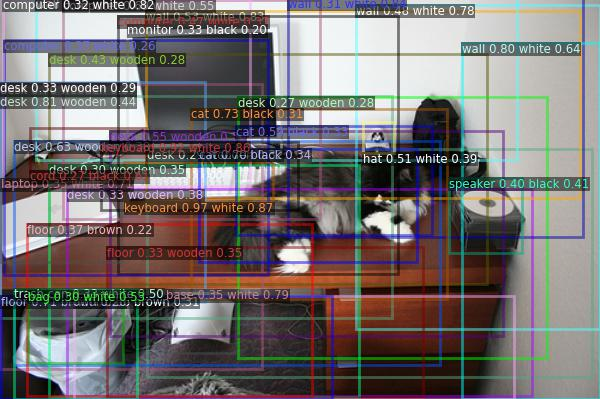

In [51]:
#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [44]:
for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: cat
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black and white
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangle
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


![test_image](https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg)

# GQA 데이터셋 버전 모델 테스트해보기

In [46]:
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"

lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [66]:
# GQA answer definition
gqa_answers = utils.get_data(GQA_URL)
print(len(gqa_answers))
print(gqa_answers[:30])

1842
['cat food', 'elephant', 'gloves', 'football', 'dock', 'shops', 'water', 'light blue', 'chair', 'players', 'tourist', 'magnet', 'railroad', 'ski lift', 'mirror', 'leggings', 'hurdle', 'shuttle', 'wildflowers', 'flowers', 'cooking pot', 'pipe', 'swan', 'girl', 'celery', 'brown', 'ambulance', 'steps', 'power line', 'asphalt']


In [52]:
lxmert_gqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-gqa-uncased")

In [53]:
output_gqa = lxmert_gqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_gqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[2.1278, 0.1617, 1.1929,  ..., 1.1576, 0.2529, 2.8312]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [54]:
# question_answering_score : 3129가지 answer dictionary 에 대한 각각의 score
# 이 score가 가장 높은 것이 답이 된다
len(output_gqa["question_answering_score"][0])

1842

In [67]:
# get prediction
pred_gqa = output_gqa["question_answering_score"].argmax(-1)

pred_gqa

tensor([640])

In [68]:
gqa_answers[640]

'desk'

In [69]:
print("Question:", test_question)
print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT GQA: desk


In [70]:
for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT GQA: desk
Question: ['What is near the disk?']
prediction from LXMERT GQA: can
Question: ['What is the color of the table?']
prediction from LXMERT GQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT GQA: black
Question: ['What is the shape of the monitor?']
prediction from LXMERT GQA: square
Question: ['What is the color of the keyboard?']
prediction from LXMERT GQA: white


# VQA/GQA 버전 비교해 보기

In [72]:
for test_question in test_questions_for_url2:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])
    print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
prediction from LXMERT GQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: cat
prediction from LXMERT GQA: can
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
prediction from LXMERT GQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black and white
prediction from LXMERT GQA: black
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangle
prediction from LXMERT GQA: square
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white
prediction from LXMERT GQA: white


### 다른 이미지로 테스트

In [74]:
URL = "https://blog.kakaocdn.net/dn/vdwGQ/btqF63CDpAJ/r93KwE8tnAtGt3nFqKB3YK/img.png"

In [75]:
images, sizes, scales_yx = image_preprocess(URL)

In [76]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [77]:
# 모델에 입력할 feature
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

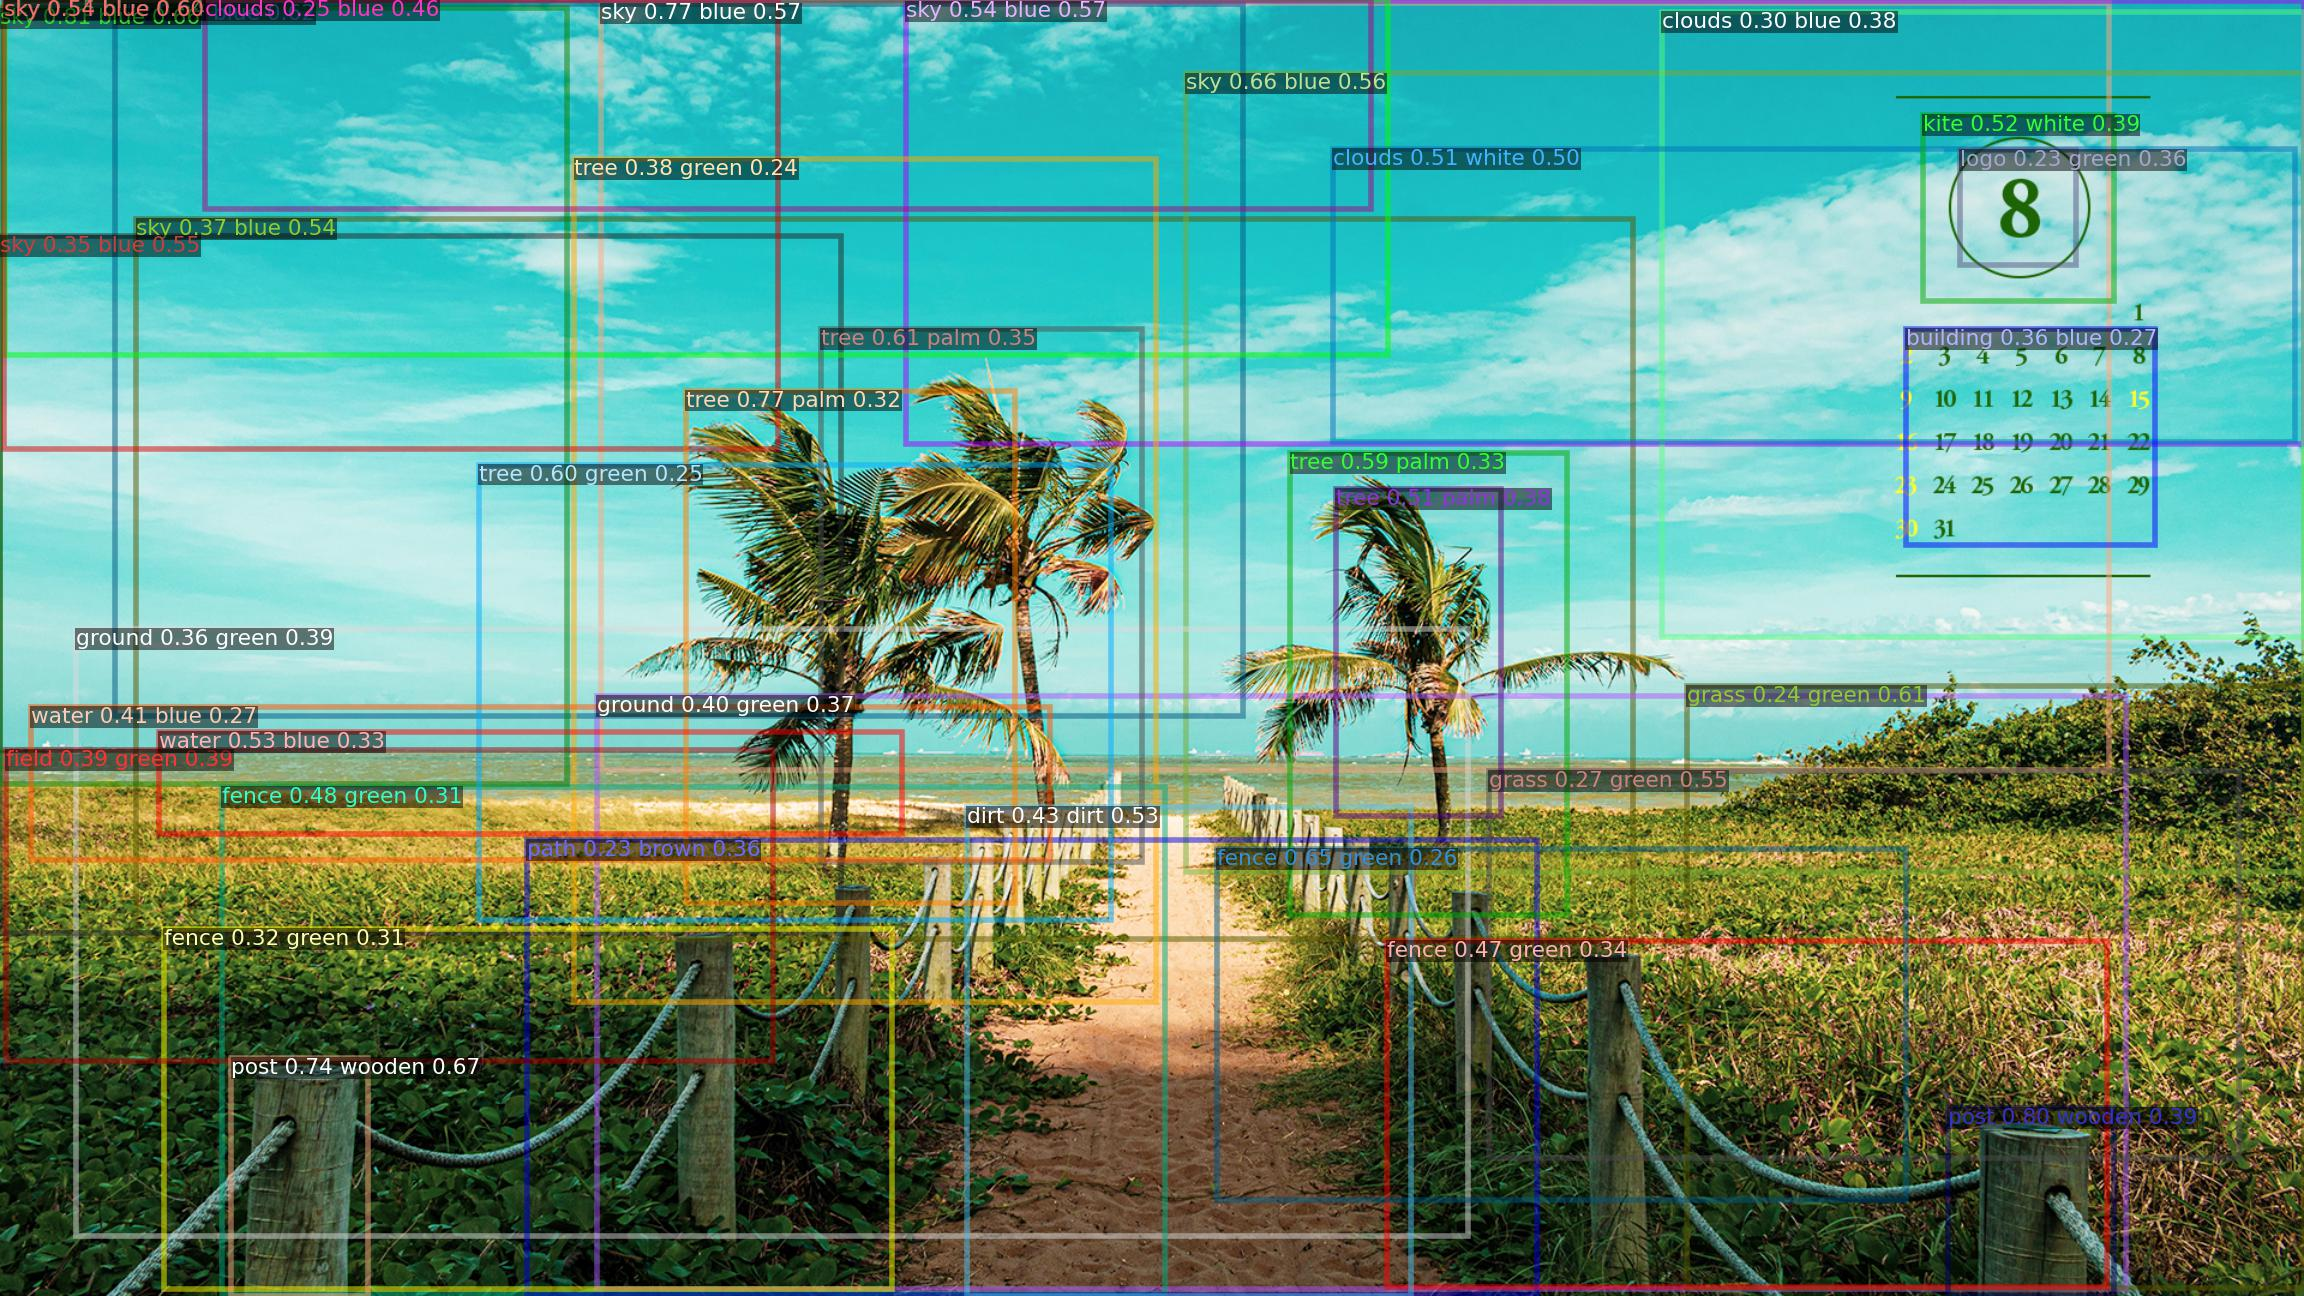

In [78]:
#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [79]:
test_questions_for_url3 = [
    "What is the weather?",
    "How many trees are there?",
    "What color is the flower?",
    "What is beyong grass?",
]

In [80]:
for test_question in test_questions_for_url3:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    
    output_gqa = lxmert_gqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    pred_gqa = output_gqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])
    print("prediction from LXMERT GQA:", gqa_answers[pred_gqa])

Question: ['What is the weather?']
prediction from LXMERT VQA: sunny
prediction from LXMERT GQA: partly cloudy
Question: ['How many trees are there?']
prediction from LXMERT VQA: 4
prediction from LXMERT GQA: butterfly
Question: ['What color is the flower?']
prediction from LXMERT VQA: green
prediction from LXMERT GQA: white
Question: ['What is beyong grass?']
prediction from LXMERT VQA: fence
prediction from LXMERT GQA: fence
